<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install d2lzh mxnet
%matplotlib inline
import d2lzh as d2l
from d2lzh import *
from mxnet.gluon import data as gdata
import sys
import time

# data

In [0]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [0]:
feature, label = mnist_train[0]

In [5]:
feature.shape, feature.dtype

((28, 28, 1), numpy.uint8)

In [6]:
label, type(label), label.dtype

(2, numpy.int32, dtype('int32'))

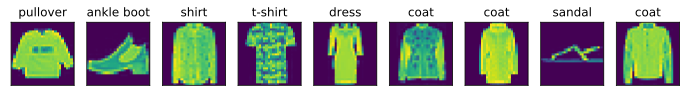

In [7]:
X, y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

# batch

In [0]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4

train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                              batch_size, shuffle=True,
                              num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                             batch_size, shuffle=False,
                             num_workers=num_workers)

In [9]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'4.94 sec'

# model

In [0]:
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

In [0]:
W.attach_grad()
b.attach_grad()

# softmax

In [12]:
X = nd.array([[1, 2, 3], [4, 5, 6]])
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(
 [[5. 7. 9.]]
 <NDArray 1x3 @cpu(0)>, 
 [[ 6.]
  [15.]]
 <NDArray 2x1 @cpu(0)>)

In [0]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

In [14]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.21324193 0.33961776 0.1239742  0.27106097 0.05210521]
  [0.11462264 0.3461234  0.19401033 0.29583326 0.04941036]]
 <NDArray 2x5 @cpu(0)>, 
 [1.0000001 1.       ]
 <NDArray 2 @cpu(0)>)

# net

In [0]:
def net(X):
  return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

# loss

In [0]:
def cross_entropy(y_hat, y):
  return -nd.pick(y_hat, y).log()

# metric

In [0]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

# train

In [18]:
num_epochs, lr = 10,0.1

# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)  # “softmax回归的简洁实现”一节将用到
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size,
          [W, b], lr)

epoch 1, loss 0.7903, train acc 0.747, test acc 0.800
epoch 2, loss 0.5742, train acc 0.811, test acc 0.822
epoch 3, loss 0.5299, train acc 0.823, test acc 0.832
epoch 4, loss 0.5058, train acc 0.830, test acc 0.835
epoch 5, loss 0.4897, train acc 0.834, test acc 0.841
epoch 6, loss 0.4774, train acc 0.838, test acc 0.843
epoch 7, loss 0.4693, train acc 0.841, test acc 0.841
epoch 8, loss 0.4619, train acc 0.843, test acc 0.845
epoch 9, loss 0.4558, train acc 0.844, test acc 0.848
epoch 10, loss 0.4507, train acc 0.846, test acc 0.850


# test

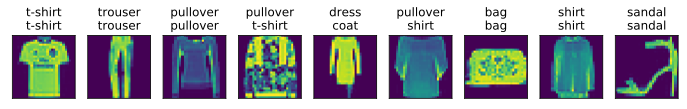

In [19]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])